# Datasets (Sentiment) - Yelp - Categories

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
! pip install jsonlines

In [ ]:
! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

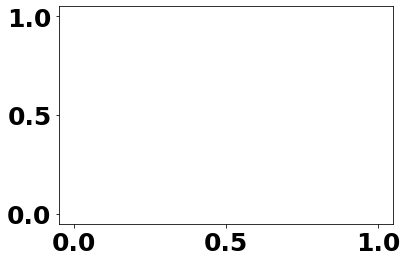

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [49]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

##### Make category comparisons

In [13]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [14]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [15]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [57]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [58]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [59]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [60]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [20]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [21]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [22]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [23]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [24]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [25]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:39, 167629.12it/s]


#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [50]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:02, 87559.26it/s] 
100%|██████████| 192127/192127 [00:00<00:00, 776344.18it/s]


#### Load category tree

- hierarchy of categories

In [51]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [61]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

---

---

---

## Experiment

#### Print category trees

In [ ]:
print_category_tree(map_categories)

In [ ]:
print_category_tree_with_num_businesses(map_categories, inv_cat_bids)

In [ ]:
print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id)

In [ ]:
print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id)

In [ ]:
print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id)

In [ ]:
### TEST ###
# because ``inv_cat_bids`` contained duplicate ids!
businesses = inv_cat_bids["Food"]
print(f"""Food: {len(businesses)}, {len(set(businesses))}""")

businesses_cnt = Counter(businesses)
businesses_cnt.most_common(10)

# inv_bid_cats["UupxKYWMnE6uq_eELO4CBQ"]
# [(c, [bi for bi in b if bi == "UupxKYWMnE6uq_eELO4CBQ"]) for c, b in inv_cat_bids.items() if "UupxKYWMnE6uq_eELO4CBQ" in b]

##### Overlap of businesses (ids) for two categories

In [ ]:
businesses_food = get_businesses_in_category_branch(inv_cat_bids, "Food", map_categories, map_cat_name2id)
businesses_restaurants = get_businesses_in_category_branch(inv_cat_bids, "Restaurants", map_categories, map_cat_name2id)

print(f"""Food:        {len(set(businesses_food)):>5d}""")
print(f"""Restaurants: {len(set(businesses_restaurants)):>5d}""")
print(f"""Both:  same: {len(set(businesses_food) & set(businesses_restaurants)):>5d}""")
print(f"""      total: {len(set(businesses_food) | set(businesses_restaurants)):>5d}""")
print()

print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, "Food", "Restaurants")

In [ ]:
root_categories = get_root_category_items(map_categories)

#### Category overlap heatmap

In [53]:
category_overlap_array, root_category_labels, df_cm = make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id)

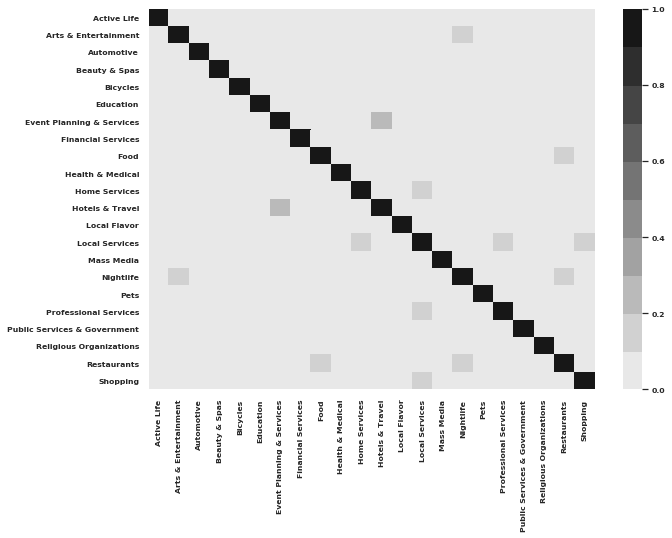

In [54]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}, cmap=sn.color_palette("binary", 10)) # font size
plt.show()

In [ ]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}, cmap=sn.color_palette("binary", 50)) # font size
plt.show()

In [ ]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 50)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

In [ ]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

---

##### Test filter : load single and filter others

In [63]:
df_food = load_cached_root_category_businesses_df("Food", map_categories)
# df_food = get_reviews_for_category(df, "Food", inv_cat_bids, map_categories, map_cat_name2id)

df_uniq_food = filter_root_category_businesses_uniq("Food", inv_cat_bids, map_categories, map_cat_name2id)

len(df), len(df_food), len(df_uniq_food)

Filter businesses from category Active Life [active] (9521 businesses) ...
Filtered 8634 businesses (overlap with Active Life)
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 49706 businesses (overlap with Arts & Entertainment)
Filter businesses from category Automotive [auto] (13203 businesses) ...
Filtered 12560 businesses (overlap with Automotive)
Filter businesses from category Beauty & Spas [beautysvc] (19370 businesses) ...
Filtered 6506 businesses (overlap with Beauty & Spas)
Filter businesses from category Bicycles [bicycles] (9 businesses) ...
Filtered 0 businesses (overlap with Bicycles)
Filter businesses from category Education [education] (3314 businesses) ...
Filtered 2203 businesses (overlap with Education)
Filter businesses from category Event Planning & Services [eventservices] (10371 businesses) ...
Filtered 87460 businesses (overlap with Event Planning & Services)
Filter businesses from category Financial Services [financials

(6685900, 1511092, 269013)

---

In [64]:
cat_name = "Food"
# cat_name = "Public Services & Government"

df_food = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

Food: 72013, uniq: 29989


In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df_food = filter_min_review_freq(df_food, min_ratings=5)

In [ ]:
tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

df_food = df_food.progress_apply(tokenize_text, axis=1)

In [ ]:
def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

df_food = df_food.progress_apply(count_words, axis=1)

In [ ]:
df_food.info()

In [ ]:
df_food.describe()

In [ ]:
df_food["num_words"].mean()

In [ ]:
cat_name, df_food["num_words"].mean()

In [ ]:
root_category_labels

In [ ]:
df_roots = list()

tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

for root_category_label in root_category_labels:
    df_rootcat = get_reviews_for_category(df, root_category_label, inv_cat_bids, map_categories, map_cat_name2id)
    
    df_rootcat = filter_min_review_freq(df_rootcat, min_ratings=5)

    df_rootcat = df_rootcat.progress_apply(tokenize_text, axis=1)
    
    df_rootcat = df_rootcat.progress_apply(count_words, axis=1)
    
    # df_roots.append(df_rootcat)
    print(f"""{root_category_label}: {df_rootcat["num_words"].mean()}""")

In [ ]:
for root_category_label, df_rootcat in zip(root_category_labels, df_roots):
    print(f"""{root_category_label}: {df_rootcat["num_words"].mean()}""")

In [ ]:
import pickle

fn_root_cat_reviews = data_yelp_path / "df_root_cat_reviews.p"

with open(fn_root_cat_reviews, "wb") as fp:
    pickle.dump(root_category_labels, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(df_roots, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

---

---

### Filter all reviews - can only contain top50 Topics

In [ ]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
f_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats)
f_inv_cat_bids = make_map_cats(f_inv_bid_cats)
f_inv_cat_combis = make_cat_combis(f_inv_bid_cats)
f_cat_pairs = make_cat_Ntuples(f_inv_cat_combis, n=2)

### Filter with minimum number of category combination occurrences

In [ ]:
f_cats = get_Ntop_cats(inv_cat_bids, n=50)
# f_cats = None

avg_num_of_cat_combis = int(sum(list(f_inv_cat_combis.values())) / len(f_inv_cat_combis))
fi_inv_cat_combis = filter_min_cat_combis(inv_cat_combis, min_num=30)

f2_inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=f_cats, filter_cat_combis=fi_inv_cat_combis)

f2_inv_cat_bids = make_map_cats(f2_inv_bid_cats)
f2_inv_cat_combis = make_cat_combis(f2_inv_bid_cats)
f2_cat_pairs = make_cat_Ntuples(f2_inv_cat_combis, n=2)

### Make NxN map and heatmap it

In [ ]:
df_cm, cat_array, cat_labels = make_NxN_map(f_cats, f2_cat_pairs)

#### Clustering

In [ ]:
plt.figure(figsize = (10, 7))
sn.set(font_scale=0.7) # for label size
sn.heatmap(df_cm, annot=False, annot_kws={"size": 10}) # font size
plt.show()

In [ ]:
plt.figure(figsize = (16, 16))
sn.set(font_scale=0.7) # for label size
# pal = sn.dark_palette("palegreen", as_cmap=True, reverse=True)
pal = sn.color_palette("binary", 10)  # PuBu - BuGn - RdPu - Greys
sn.clustermap(df_cm, annot_kws={"size": 5}, cmap=pal)  # cmap="vlag") # plt.cm.Blues)

In [ ]:
Z = hierarchy.linkage(df_cm, "ward")
#hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [ ]:
df_cm2 = ssd.squareform(df_cm)

Z = hierarchy.linkage(df_cm2, "ward")
hierarchy.set_link_color_palette(['#b30000','#996600', '#b30086'])
R = hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=df_cm.index)

In [ ]:
sc = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
cluster_labels = sc.fit_predict(cat_array)

# sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

In [ ]:
ac = AgglomerativeClustering(4, affinity='euclidean', linkage='ward')
csarr = cosine_similarity(cat_array)
cluster_labels = ac.fit_predict(csarr)

# sorted(list(zip(labels, cluster_labels)), key=lambda x: x[1])

groups = list()
for g, data in groupby(sorted(list(zip(cat_labels, cluster_labels)), key=lambda x: x[1]), key=lambda x: x[1]):
    group = [t for t, _ in data]
    groups.append(group)

    print(f"Group {g}:")
    print("; ".join(group))
    print()

In [ ]:
# cat_array, \
# linear_kernel(cat_array), \
# cosine_similarity(cat_array), \
# cat_labels

### Stats for `cat_labels` in filtered category maps/lists etc.

In [ ]:
# number of business ids given a specific category
sorted([(c, len(f_inv_cat_bids[c])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# number of category combinations given a specific category
sorted([(c, len([cc for cc in f2_inv_cat_combis.keys() if c in cc])) for c in cat_labels], key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# better with filtering
# category pairs for a given category
sorted([(c, [cc for cc in f2_cat_pairs.keys() if c in cc]) for c in cat_labels], key=lambda x: len(x[1]), reverse=True)[:5]

In [ ]:
# category pairs for a category:
c = "Food"

print("filtered by top50\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f_cat_pairs.keys() if c in cc]])
print()
print("filtered by avg amount (+top50)\n", [c1 if c1 != c else c2 for c1, c2 in [cc for cc in f2_cat_pairs.keys() if c in cc]])

In [ ]:
f2_inv_cat_combis[("Food",)]  # businesses with only this category ... (filtering should not affect this value)

In [ ]:
f2_inv_cat_combis

In [ ]:
inv_bid_cats = f2_inv_bid_cats
inv_cat_bids = f2_inv_cat_bids
inv_cat_combis = f2_inv_cat_combis
cat_pairs = f2_cat_pairs

In [ ]:
sum([len(b) for a, b in f2_inv_cat_bids.items()])

In [ ]:
inv_bid_cats = load_topics(fn_yelp_topics)
sum([len(b) for a, b in inv_cat_bids.items()])

In [ ]:
https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
len(f2_inv_cat_combis)  # number of category combinations

---

#### Statistics

In [ ]:
print(f"Number of businesses with categories: {len(inv_bid_cats):>6}")
print(f"                  without categories: {len(bids_not_cats):>6}")
print(f"Number of categories: len(inv_cat_bids) = {len(inv_cat_bids)}")

In [ ]:
inv_cat_combis.most_common(20)

In [ ]:
# count single categories
cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
cnt.most_common(20)

#### Filter reviews with at least N ratings

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df = filter_min_review_freq(df, min_ratings=5)

#### Filter only reviews with both good and bad rating

In [ ]:
df = filter_both_good_bad(df)

#### Make pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [ ]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [ ]:
pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=2)

print("#ss (pos)", len(pairs_good))
print("#ss (neg)", len(pairs_bad))

##### not same-sentiment pairs (combinations positive + negative)

In [ ]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [ ]:
pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)

print("#nss", len(pairs_not_ss))

##### dataframe for training etc.

In [ ]:
pairs_all = pairs_good + pairs_bad + pairs_not_ss
print("#~ss", len(pairs_all))

# print(pairs_all[0]["argument1_id"])
np.random.shuffle(pairs_all)
# print(pairs_all[0]["argument1_id"])

df_traindev = pd.DataFrame.from_dict(pairs_all)

In [ ]:
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "wb") as fp:
    pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

#### Reloading for training

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

In [ ]:
# len(traindev_df), len(test_df)

---
---
---

## Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
! pip install --upgrade mxnet-cu102
! pip install --upgrade gluonnlp 

In [ ]:
! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [73]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X_arteval, names_columns_y

In [66]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

---

In [67]:
run_name = "yelp_3_food_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "Food"

! mkdir data/yelp_3_food_pro128BCE

mkdir: cannot create directory ‘data/yelp_3_food_pro128BCE’: File exists


---

In [68]:
df_food = load_cached_root_category_businesses_df(category_name, map_categories)
# df_food = get_reviews_for_category(df, category_name, inv_cat_bids, map_categories, map_cat_name2id)

df_uniq_food = filter_root_category_businesses_uniq(category_name, inv_cat_bids, map_categories, map_cat_name2id)

len(df), len(df_food), len(df_uniq_food)

Filter businesses from category Active Life [active] (9521 businesses) ...
Filtered 8634 businesses (overlap with Active Life)
Filter businesses from category Arts & Entertainment [arts] (6304 businesses) ...
Filtered 49706 businesses (overlap with Arts & Entertainment)
Filter businesses from category Automotive [auto] (13203 businesses) ...
Filtered 12560 businesses (overlap with Automotive)
Filter businesses from category Beauty & Spas [beautysvc] (19370 businesses) ...
Filtered 6506 businesses (overlap with Beauty & Spas)
Filter businesses from category Bicycles [bicycles] (9 businesses) ...
Filtered 0 businesses (overlap with Bicycles)
Filter businesses from category Education [education] (3314 businesses) ...
Filtered 2203 businesses (overlap with Education)
Filter businesses from category Event Planning & Services [eventservices] (10371 businesses) ...
Filtered 87460 businesses (overlap with Event Planning & Services)
Filter businesses from category Financial Services [financials

(6685900, 1511092, 269013)

In [ ]:
df_td = df_uniq_food

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df_td = filter_min_review_freq(df_td, min_ratings=5)

In [ ]:
df_td = filter_both_good_bad(df_td)

In [ ]:
traindev_df = make_or_load_pairs(df_td, str(fn_traindev_df), num_pairs_per_class=2)

In [ ]:
len(traindev_df)  # pairs

---

In [ ]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
traindev_df["tag"] = "NA"

In [ ]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [33]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=1)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:02.588552


In [ ]:
with Timer("prepare training / validation data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

In [34]:
num_epochs = 3
batch_size = 32

##### Training with TRAIN set

In [ ]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

In [ ]:
plot_train_stats(stats)

##### Results with validation set (DEV set)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

In [ ]:
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 3 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

### Load other categories and evaluate

In [74]:
fn_model_state = fn_run_path / f"bert.model.checkpoint{num_epochs - 1}.params"
print(f"Load {fn_model_state} ...")
model.load_parameters(str(fn_model_state), ctx=ctx)

Load data/yelp_3_food_pro128BCE/bert.model.checkpoint2.params ...


In [70]:
# lst_root_categories
root_categories = get_root_category_items(map_categories)
root_categories = sorted(root_categories, key=lambda x: x["title"])
root_category_labels = [x["title"] for x in root_categories]

Work on Active Life ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 8634 businesses (overlap with Food)


  2%|▏         | 36/1969 [00:00<00:05, 359.51it/s]

#ss (pos) 3938
#ss (neg) 3938


100%|██████████| 1969/1969 [00:04<00:00, 478.91it/s]


#nss 7876
#~ss 15752
review pairs: 15752


  0%|          | 1/493 [00:00<00:51,  9.49it/s]

Start on [prediction] ...


100%|██████████| 493/493 [00:47<00:00, 10.44it/s]


Time for [prediction]: 0:00:47.238626
Confusion Matrix:
[[5974 1902]
 [2020 5856]]

CM: [5974 1902 2020 5856] 
[tn, fp, fn, tp]
  accuracy: 0.751
 precision: 0.751
    recall: 0.751
  f1-score: 0.751

Accuracy:  0.751 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Active Life]:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      7876
           1       0.75      0.74      0.75      7876

    accuracy                           0.75     15752
   macro avg       0.75      0.75      0.75     15752
weighted avg       0.75      0.75      0.75     15752



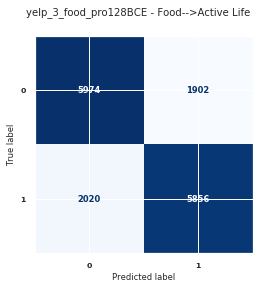

Work on Arts & Entertainment ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 53758 businesses (overlap with Food)


  1%|          | 14/1986 [00:00<00:14, 137.33it/s]

#ss (pos) 3972
#ss (neg) 3972


100%|██████████| 1986/1986 [00:04<00:00, 472.91it/s]


#nss 7944
#~ss 15888
review pairs: 15888


  0%|          | 1/497 [00:00<00:53,  9.25it/s]

Start on [prediction] ...


100%|██████████| 497/497 [00:47<00:00, 10.37it/s]


Time for [prediction]: 0:00:47.924836
Confusion Matrix:
[[5621 2323]
 [2286 5658]]

CM: [5621 2323 2286 5658] 
[tn, fp, fn, tp]
  accuracy: 0.710
 precision: 0.710
    recall: 0.710
  f1-score: 0.710

Accuracy:  0.71 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Arts & Entertainment]:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      7944
           1       0.71      0.71      0.71      7944

    accuracy                           0.71     15888
   macro avg       0.71      0.71      0.71     15888
weighted avg       0.71      0.71      0.71     15888



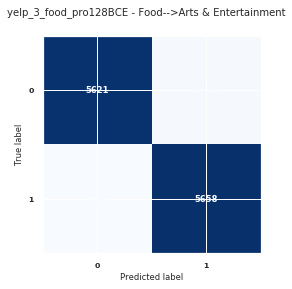

Work on Automotive ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 12623 businesses (overlap with Food)


  1%|▏         | 34/2697 [00:00<00:07, 338.90it/s]

#ss (pos) 5394
#ss (neg) 5394


100%|██████████| 2697/2697 [00:05<00:00, 484.69it/s]


#nss 10788
#~ss 21576
review pairs: 21576


  0%|          | 1/675 [00:00<01:16,  8.79it/s]

Start on [prediction] ...


100%|██████████| 675/675 [01:05<00:00, 10.36it/s]


Time for [prediction]: 0:01:05.133627
Confusion Matrix:
[[8346 2442]
 [1999 8789]]

CM: [8346 2442 1999 8789] 
[tn, fp, fn, tp]
  accuracy: 0.794
 precision: 0.795
    recall: 0.794
  f1-score: 0.794

Accuracy:  0.794 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Automotive]:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     10788
           1       0.78      0.81      0.80     10788

    accuracy                           0.79     21576
   macro avg       0.79      0.79      0.79     21576
weighted avg       0.79      0.79      0.79     21576



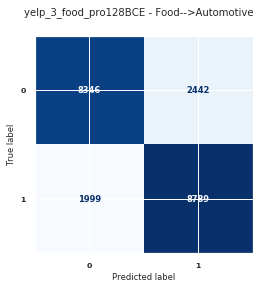

Work on Beauty & Spas ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 11899 businesses (overlap with Food)


  0%|          | 0/4863 [00:00<?, ?it/s]

#ss (pos) 9726
#ss (neg) 9726


100%|██████████| 4863/4863 [00:10<00:00, 479.96it/s]


#nss 19452
#~ss 38904
review pairs: 38904


  0%|          | 1/1216 [00:00<02:37,  7.72it/s]

Start on [prediction] ...


100%|██████████| 1216/1216 [01:56<00:00, 10.44it/s]


Time for [prediction]: 0:01:56.467390
Confusion Matrix:
[[15767  3685]
 [ 3407 16045]]

CM: [15767  3685  3407 16045] 
[tn, fp, fn, tp]
  accuracy: 0.818
 precision: 0.818
    recall: 0.818
  f1-score: 0.818

Accuracy:  0.818 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     19452
           1       0.81      0.82      0.82     19452

    accuracy                           0.82     38904
   macro avg       0.82      0.82      0.82     38904
weighted avg       0.82      0.82      0.82     38904



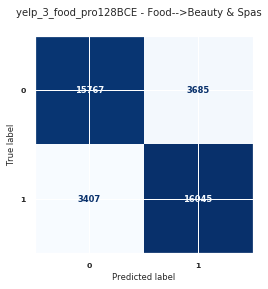

100%|██████████| 1/1 [00:00<00:00, 30.99it/s]

Work on Bicycles ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 0 businesses (overlap with Food)
#ss (pos) 2
#ss (neg) 2
#nss 4
#~ss 8
review pairs: 8
Start on [prediction] ...
Time for [prediction]: 0:00:00.033849
Confusion Matrix:
[[2 2]
 [0 4]]

CM: [2 2 0 4] 
[tn, fp, fn, tp]
  accuracy: 0.750
 precision: 0.833
    recall: 0.750
  f1-score: 0.733

Accuracy:  0.75 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Bicycles]:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.67      1.00      0.80         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



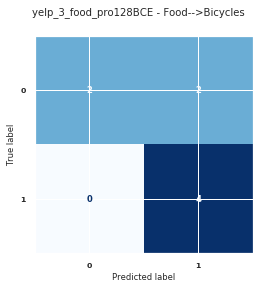

Work on Education ...


  0%|          | 0/408 [00:00<?, ?it/s]

Filter businesses from category Food [food] (29989 businesses) ...
Filtered 3929 businesses (overlap with Food)


 12%|█▏        | 48/408 [00:00<00:00, 478.73it/s]

#ss (pos) 816
#ss (neg) 816


100%|██████████| 408/408 [00:00<00:00, 487.30it/s]


#nss 1632
#~ss 3264
review pairs: 3264


  1%|          | 1/102 [00:00<00:11,  8.80it/s]

Start on [prediction] ...


100%|██████████| 102/102 [00:10<00:00,  9.86it/s]

Time for [prediction]: 0:00:10.345083
Confusion Matrix:
[[1227  405]
 [ 390 1242]]

CM: [1227  405  390 1242] 
[tn, fp, fn, tp]
  accuracy: 0.756
 precision: 0.756
    recall: 0.756
  f1-score: 0.756

Accuracy:  0.756 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Education]:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1632
           1       0.75      0.76      0.76      1632

    accuracy                           0.76      3264
   macro avg       0.76      0.76      0.76      3264
weighted avg       0.76      0.76      0.76      3264



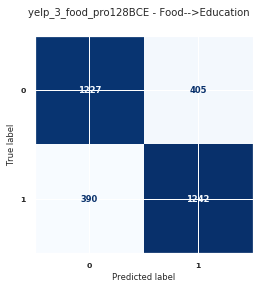

Work on Event Planning & Services ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 109223 businesses (overlap with Food)


  0%|          | 0/3072 [00:00<?, ?it/s]

#ss (pos) 6144
#ss (neg) 6144


100%|██████████| 3072/3072 [00:06<00:00, 484.83it/s]


#nss 12288
#~ss 24576
review pairs: 24576


  0%|          | 1/768 [00:00<01:29,  8.60it/s]

Start on [prediction] ...


100%|██████████| 768/768 [01:14<00:00, 10.24it/s]


Time for [prediction]: 0:01:14.988550
Confusion Matrix:
[[9216 3072]
 [3241 9047]]

CM: [9216 3072 3241 9047] 
[tn, fp, fn, tp]
  accuracy: 0.743
 precision: 0.743
    recall: 0.743
  f1-score: 0.743

Accuracy:  0.743 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74     12288
           1       0.75      0.74      0.74     12288

    accuracy                           0.74     24576
   macro avg       0.74      0.74      0.74     24576
weighted avg       0.74      0.74      0.74     24576



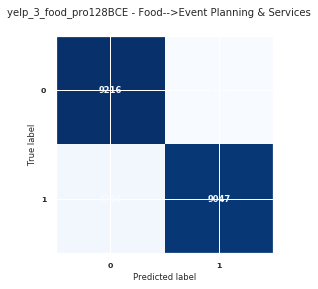

 17%|█▋        | 50/294 [00:00<00:00, 498.32it/s]

Work on Financial Services ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 208 businesses (overlap with Food)


 17%|█▋        | 50/294 [00:00<00:00, 496.77it/s]

#ss (pos) 588
#ss (neg) 588


  0%|          | 0/74 [00:00<?, ?it/s]

#nss 1176
#~ss 2352
review pairs: 2352
Start on [prediction] ...


100%|██████████| 74/74 [00:06<00:00, 10.60it/s]


Time for [prediction]: 0:00:06.979767
Confusion Matrix:
[[928 248]
 [210 966]]

CM: [928 248 210 966] 
[tn, fp, fn, tp]
  accuracy: 0.805
 precision: 0.806
    recall: 0.805
  f1-score: 0.805

Accuracy:  0.805 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Financial Services]:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1176
           1       0.80      0.82      0.81      1176

    accuracy                           0.81      2352
   macro avg       0.81      0.81      0.81      2352
weighted avg       0.81      0.81      0.81      2352



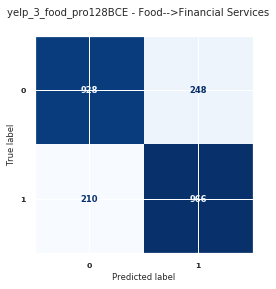

Work on Health & Medical ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 7032 businesses (overlap with Food)


  1%|▏         | 40/3093 [00:00<00:07, 392.34it/s]

#ss (pos) 6186
#ss (neg) 6186


100%|██████████| 3093/3093 [00:06<00:00, 493.33it/s]


#nss 12372
#~ss 24744
review pairs: 24744


  0%|          | 1/774 [00:00<01:33,  8.30it/s]

Start on [prediction] ...


100%|██████████| 774/774 [01:15<00:00, 10.23it/s]


Time for [prediction]: 0:01:15.697615
Confusion Matrix:
[[ 9825  2547]
 [ 2016 10356]]

CM: [ 9825  2547  2016 10356] 
[tn, fp, fn, tp]
  accuracy: 0.816
 precision: 0.816
    recall: 0.816
  f1-score: 0.816

Accuracy:  0.816 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     12372
           1       0.80      0.84      0.82     12372

    accuracy                           0.82     24744
   macro avg       0.82      0.82      0.82     24744
weighted avg       0.82      0.82      0.82     24744



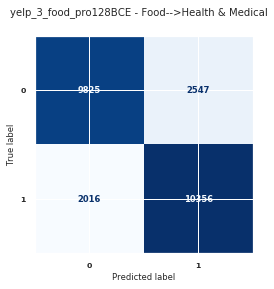

Work on Home Services ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 2792 businesses (overlap with Food)


  1%|          | 37/3069 [00:00<00:08, 369.36it/s]

#ss (pos) 6138
#ss (neg) 6138


100%|██████████| 3069/3069 [00:06<00:00, 493.79it/s]


#nss 12276
#~ss 24552
review pairs: 24552


  0%|          | 1/768 [00:00<01:27,  8.80it/s]

Start on [prediction] ...


100%|██████████| 768/768 [01:16<00:00, 10.08it/s]


Time for [prediction]: 0:01:16.180018
Confusion Matrix:
[[ 9418  2858]
 [ 2149 10127]]

CM: [ 9418  2858  2149 10127] 
[tn, fp, fn, tp]
  accuracy: 0.796
 precision: 0.797
    recall: 0.796
  f1-score: 0.796

Accuracy:  0.796 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Home Services]:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     12276
           1       0.78      0.82      0.80     12276

    accuracy                           0.80     24552
   macro avg       0.80      0.80      0.80     24552
weighted avg       0.80      0.80      0.80     24552



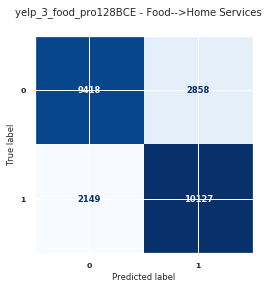

Work on Hotels & Travel ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 22032 businesses (overlap with Food)


  1%|          | 19/2155 [00:00<00:11, 188.38it/s]

#ss (pos) 4310
#ss (neg) 4310


100%|██████████| 2155/2155 [00:04<00:00, 469.78it/s]


#nss 8620
#~ss 17240
review pairs: 17240


  0%|          | 1/539 [00:00<01:00,  8.83it/s]

Start on [prediction] ...


100%|██████████| 539/539 [00:53<00:00, 10.14it/s]


Time for [prediction]: 0:00:53.171428
Confusion Matrix:
[[6355 2265]
 [2353 6267]]

CM: [6355 2265 2353 6267] 
[tn, fp, fn, tp]
  accuracy: 0.732
 precision: 0.732
    recall: 0.732
  f1-score: 0.732

Accuracy:  0.732 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      8620
           1       0.73      0.73      0.73      8620

    accuracy                           0.73     17240
   macro avg       0.73      0.73      0.73     17240
weighted avg       0.73      0.73      0.73     17240



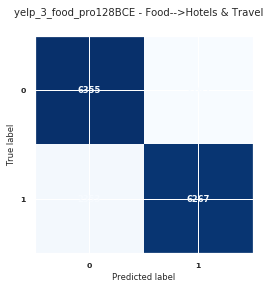

Work on Local Flavor ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 34515 businesses (overlap with Food)


 15%|█▍        | 45/304 [00:00<00:00, 448.64it/s]

#ss (pos) 608
#ss (neg) 608


100%|██████████| 304/304 [00:00<00:00, 472.65it/s]


#nss 1216
#~ss 2432
review pairs: 2432


  1%|▏         | 1/76 [00:00<00:08,  8.41it/s]

Start on [prediction] ...


100%|██████████| 76/76 [00:07<00:00, 10.17it/s]

Time for [prediction]: 0:00:07.471167
Confusion Matrix:
[[861 355]
 [372 844]]

CM: [861 355 372 844] 
[tn, fp, fn, tp]
  accuracy: 0.701
 precision: 0.701
    recall: 0.701
  f1-score: 0.701

Accuracy:  0.701 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1216
           1       0.70      0.69      0.70      1216

    accuracy                           0.70      2432
   macro avg       0.70      0.70      0.70      2432
weighted avg       0.70      0.70      0.70      2432



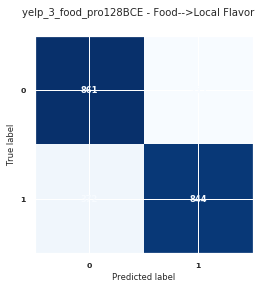

Work on Local Services ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 3566 businesses (overlap with Food)


  2%|▏         | 42/2295 [00:00<00:05, 419.04it/s]

#ss (pos) 4590
#ss (neg) 4590


100%|██████████| 2295/2295 [00:04<00:00, 495.46it/s]


#nss 9180
#~ss 18360
review pairs: 18360


  0%|          | 1/574 [00:00<01:02,  9.11it/s]

Start on [prediction] ...


100%|██████████| 574/574 [00:55<00:00, 10.41it/s]


Time for [prediction]: 0:00:55.155578
Confusion Matrix:
[[7172 2008]
 [1695 7485]]

CM: [7172 2008 1695 7485] 
[tn, fp, fn, tp]
  accuracy: 0.798
 precision: 0.799
    recall: 0.798
  f1-score: 0.798

Accuracy:  0.798 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Local Services]:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      9180
           1       0.79      0.82      0.80      9180

    accuracy                           0.80     18360
   macro avg       0.80      0.80      0.80     18360
weighted avg       0.80      0.80      0.80     18360



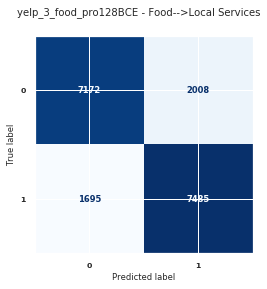

100%|██████████| 35/35 [00:00<00:00, 504.32it/s]

Work on Mass Media ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 14 businesses (overlap with Food)
#ss (pos) 70
#ss (neg) 70
#nss 140
#~ss 280
review pairs: 280



 22%|██▏       | 2/9 [00:00<00:00, 10.43it/s]

Start on [prediction] ...


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]

Time for [prediction]: 0:00:00.851013
Confusion Matrix:
[[104  36]
 [ 32 108]]

CM: [104  36  32 108] 
[tn, fp, fn, tp]
  accuracy: 0.757
 precision: 0.757
    recall: 0.757
  f1-score: 0.757

Accuracy:  0.757 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Mass Media]:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       140
           1       0.75      0.77      0.76       140

    accuracy                           0.76       280
   macro avg       0.76      0.76      0.76       280
weighted avg       0.76      0.76      0.76       280



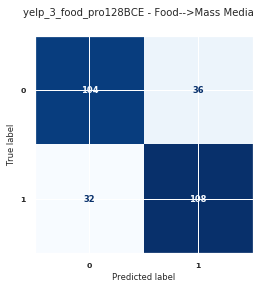

Work on Nightlife ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 270212 businesses (overlap with Food)


100%|██████████| 6597/6597 [00:14<00:00, 468.94it/s]


#ss (pos) 13194
#ss (neg) 13194


100%|██████████| 6597/6597 [00:13<00:00, 481.71it/s]


#nss 26388
#~ss 52776
review pairs: 52776


  0%|          | 1/1650 [00:00<03:25,  8.01it/s]

Start on [prediction] ...


100%|██████████| 1650/1650 [02:37<00:00, 10.45it/s]


Time for [prediction]: 0:02:37.827453
Confusion Matrix:
[[19783  6605]
 [ 7483 18905]]

CM: [19783  6605  7483 18905] 
[tn, fp, fn, tp]
  accuracy: 0.733
 precision: 0.733
    recall: 0.733
  f1-score: 0.733

Accuracy:  0.733 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Nightlife]:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     26388
           1       0.74      0.72      0.73     26388

    accuracy                           0.73     52776
   macro avg       0.73      0.73      0.73     52776
weighted avg       0.73      0.73      0.73     52776



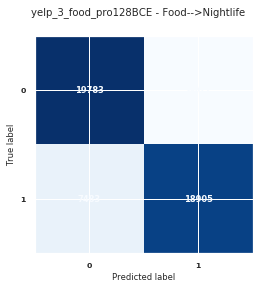

Work on Pets ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 1443 businesses (overlap with Food)


  5%|▍         | 45/983 [00:00<00:02, 449.91it/s]

#ss (pos) 1966
#ss (neg) 1966


100%|██████████| 983/983 [00:02<00:00, 486.59it/s]


#nss 3932
#~ss 7864
review pairs: 7864


  0%|          | 1/246 [00:00<00:30,  8.13it/s]

Start on [prediction] ...


100%|██████████| 246/246 [00:24<00:00, 10.01it/s]


Time for [prediction]: 0:00:24.570945
Confusion Matrix:
[[3037  895]
 [ 783 3149]]

CM: [3037  895  783 3149] 
[tn, fp, fn, tp]
  accuracy: 0.787
 precision: 0.787
    recall: 0.787
  f1-score: 0.787

Accuracy:  0.787 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Pets]:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      3932
           1       0.78      0.80      0.79      3932

    accuracy                           0.79      7864
   macro avg       0.79      0.79      0.79      7864
weighted avg       0.79      0.79      0.79      7864



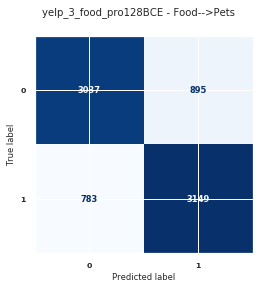

Work on Professional Services ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 1368 businesses (overlap with Food)


  7%|▋         | 47/683 [00:00<00:01, 461.89it/s]

#ss (pos) 1366
#ss (neg) 1366


100%|██████████| 683/683 [00:01<00:00, 478.15it/s]


#nss 2732
#~ss 5464
review pairs: 5464


  1%|          | 1/171 [00:00<00:18,  9.11it/s]

Start on [prediction] ...


100%|██████████| 171/171 [00:16<00:00, 10.35it/s]

Time for [prediction]: 0:00:16.527765
Confusion Matrix:
[[2118  614]
 [ 453 2279]]

CM: [2118  614  453 2279] 
[tn, fp, fn, tp]
  accuracy: 0.805
 precision: 0.806
    recall: 0.805
  f1-score: 0.805

Accuracy:  0.805 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Professional Services]:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2732
           1       0.79      0.83      0.81      2732

    accuracy                           0.80      5464
   macro avg       0.81      0.80      0.80      5464
weighted avg       0.81      0.80      0.80      5464



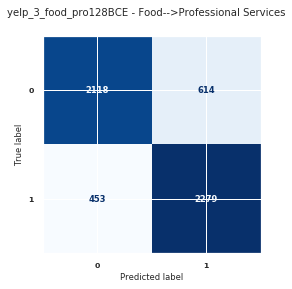

  0%|          | 0/283 [00:00<?, ?it/s]

Work on Public Services & Government ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 535 businesses (overlap with Food)


 18%|█▊        | 50/283 [00:00<00:00, 492.63it/s]

#ss (pos) 566
#ss (neg) 566


  0%|          | 0/71 [00:00<?, ?it/s]

#nss 1132
#~ss 2264
review pairs: 2264
Start on [prediction] ...


100%|██████████| 71/71 [00:06<00:00, 10.51it/s]

Time for [prediction]: 0:00:06.759141
Confusion Matrix:
[[762 370]
 [287 845]]

CM: [762 370 287 845] 
[tn, fp, fn, tp]
  accuracy: 0.710
 precision: 0.711
    recall: 0.710
  f1-score: 0.709

Accuracy:  0.71 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Public Services & Government]:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1132
           1       0.70      0.75      0.72      1132

    accuracy                           0.71      2264
   macro avg       0.71      0.71      0.71      2264
weighted avg       0.71      0.71      0.71      2264



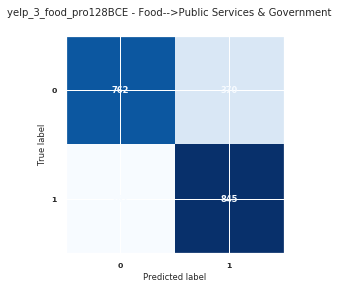

  0%|          | 0/43 [00:00<?, ?it/s]

Work on Religious Organizations ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 183 businesses (overlap with Food)


  0%|          | 0/43 [00:00<?, ?it/s]

#ss (pos) 86
#ss (neg) 86


  0%|          | 0/11 [00:00<?, ?it/s]

#nss 172
#~ss 344
review pairs: 344
Start on [prediction] ...


100%|██████████| 11/11 [00:01<00:00, 10.41it/s]

Time for [prediction]: 0:00:01.058354
Confusion Matrix:
[[124  48]
 [ 42 130]]

CM: [124  48  42 130] 
[tn, fp, fn, tp]
  accuracy: 0.738
 precision: 0.739
    recall: 0.738
  f1-score: 0.738

Accuracy:  0.738 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Religious Organizations]:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       172
           1       0.73      0.76      0.74       172

    accuracy                           0.74       344
   macro avg       0.74      0.74      0.74       344
weighted avg       0.74      0.74      0.74       344



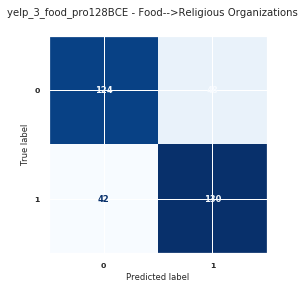

Work on Restaurants ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 1133172 businesses (overlap with Food)


100%|██████████| 25170/25170 [00:54<00:00, 457.75it/s]


#ss (pos) 50340
#ss (neg) 50340


100%|██████████| 25170/25170 [00:53<00:00, 468.73it/s]


#nss 100680
#~ss 201360
review pairs: 201360


  0%|          | 1/6293 [00:00<13:05,  8.01it/s]

Start on [prediction] ...


100%|██████████| 6293/6293 [09:57<00:00, 10.53it/s]


Time for [prediction]: 0:09:57.848214
Confusion Matrix:
[[77714 22966]
 [28194 72486]]

CM: [77714 22966 28194 72486] 
[tn, fp, fn, tp]
  accuracy: 0.746
 precision: 0.747
    recall: 0.746
  f1-score: 0.746

Accuracy:  0.746 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Restaurants]:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75    100680
           1       0.76      0.72      0.74    100680

    accuracy                           0.75    201360
   macro avg       0.75      0.75      0.75    201360
weighted avg       0.75      0.75      0.75    201360



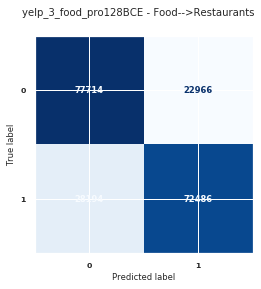

Work on Shopping ...
Filter businesses from category Food [food] (29989 businesses) ...
Filtered 73912 businesses (overlap with Food)


  0%|          | 0/5634 [00:00<?, ?it/s]

#ss (pos) 11268
#ss (neg) 11268


100%|██████████| 5634/5634 [00:11<00:00, 488.03it/s]


#nss 22536
#~ss 45072
review pairs: 45072


  0%|          | 1/1409 [00:00<03:36,  6.50it/s]

Start on [prediction] ...


100%|██████████| 1409/1409 [02:16<00:00, 10.35it/s]


Time for [prediction]: 0:02:16.093503
Confusion Matrix:
[[16986  5550]
 [ 5131 17405]]

CM: [16986  5550  5131 17405] 
[tn, fp, fn, tp]
  accuracy: 0.763
 precision: 0.763
    recall: 0.763
  f1-score: 0.763

Accuracy:  0.763 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Shopping]:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     22536
           1       0.76      0.77      0.77     22536

    accuracy                           0.76     45072
   macro avg       0.76      0.76      0.76     45072
weighted avg       0.76      0.76      0.76     45072



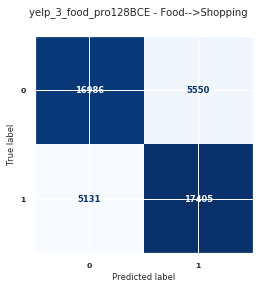

In [75]:
results_cross_no_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # without overlap
    df_other = filter_root_category_businesses_not_other(root_category_label, category_name, inv_cat_bids, map_categories, map_cat_name2id)
    
    df_other = filter_min_review_freq(df_other, min_ratings=5)
    df_other = filter_both_good_bad(df_other)
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=2)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    results_cross_no_overlap[root_category_label] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

Work on Active Life ...


  2%|▏         | 41/2039 [00:00<00:04, 406.74it/s]

#ss (pos) 4078
#ss (neg) 4078


100%|██████████| 2039/2039 [00:04<00:00, 491.66it/s]


#nss 8156
#~ss 16312
review pairs: 16312


  0%|          | 1/510 [00:00<01:08,  7.41it/s]

Start on [prediction] ...


100%|██████████| 510/510 [00:48<00:00, 10.43it/s]


Time for [prediction]: 0:00:48.881101
Confusion Matrix:
[[6058 2098]
 [2106 6050]]

CM: [6058 2098 2106 6050] 
[tn, fp, fn, tp]
  accuracy: 0.742
 precision: 0.742
    recall: 0.742
  f1-score: 0.742

Accuracy:  0.742 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Active Life]:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8156
           1       0.74      0.74      0.74      8156

    accuracy                           0.74     16312
   macro avg       0.74      0.74      0.74     16312
weighted avg       0.74      0.74      0.74     16312



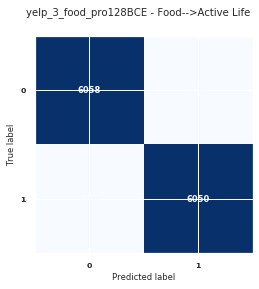

Work on Arts & Entertainment ...


  1%|          | 18/2279 [00:00<00:12, 177.81it/s]

#ss (pos) 4558
#ss (neg) 4558


100%|██████████| 2279/2279 [00:04<00:00, 469.15it/s]


#nss 9116
#~ss 18232
review pairs: 18232


  0%|          | 1/570 [00:00<01:02,  9.07it/s]

Start on [prediction] ...


100%|██████████| 570/570 [00:54<00:00, 10.38it/s]


Time for [prediction]: 0:00:54.924587
Confusion Matrix:
[[6484 2632]
 [2656 6460]]

CM: [6484 2632 2656 6460] 
[tn, fp, fn, tp]
  accuracy: 0.710
 precision: 0.710
    recall: 0.710
  f1-score: 0.710

Accuracy:  0.71 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Arts & Entertainment]:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      9116
           1       0.71      0.71      0.71      9116

    accuracy                           0.71     18232
   macro avg       0.71      0.71      0.71     18232
weighted avg       0.71      0.71      0.71     18232



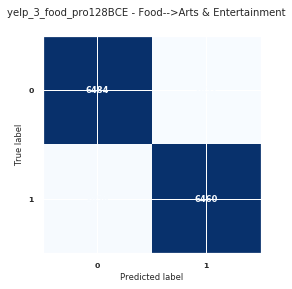

Work on Automotive ...


  1%|          | 33/2848 [00:00<00:08, 327.94it/s]

#ss (pos) 5696
#ss (neg) 5696


100%|██████████| 2848/2848 [00:05<00:00, 483.92it/s]


#nss 11392
#~ss 22784
review pairs: 22784


  0%|          | 1/712 [00:00<01:21,  8.75it/s]

Start on [prediction] ...


100%|██████████| 712/712 [01:08<00:00, 10.34it/s]


Time for [prediction]: 0:01:08.849013
Confusion Matrix:
[[8739 2653]
 [2141 9251]]

CM: [8739 2653 2141 9251] 
[tn, fp, fn, tp]
  accuracy: 0.790
 precision: 0.790
    recall: 0.790
  f1-score: 0.789

Accuracy:  0.79 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Automotive]:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     11392
           1       0.78      0.81      0.79     11392

    accuracy                           0.79     22784
   macro avg       0.79      0.79      0.79     22784
weighted avg       0.79      0.79      0.79     22784



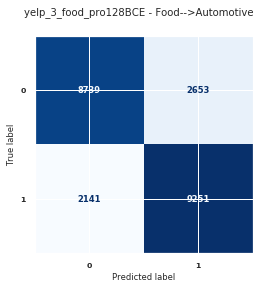

Work on Beauty & Spas ...


  0%|          | 0/4991 [00:00<?, ?it/s]

#ss (pos) 9982
#ss (neg) 9982


100%|██████████| 4991/4991 [00:10<00:00, 493.88it/s]


#nss 19964
#~ss 39928
review pairs: 39928


  0%|          | 1/1248 [00:00<02:33,  8.11it/s]

Start on [prediction] ...


100%|██████████| 1248/1248 [01:59<00:00, 10.43it/s]


Time for [prediction]: 0:01:59.627793
Confusion Matrix:
[[16119  3845]
 [ 3465 16499]]

CM: [16119  3845  3465 16499] 
[tn, fp, fn, tp]
  accuracy: 0.817
 precision: 0.817
    recall: 0.817
  f1-score: 0.817

Accuracy:  0.817 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     19964
           1       0.81      0.83      0.82     19964

    accuracy                           0.82     39928
   macro avg       0.82      0.82      0.82     39928
weighted avg       0.82      0.82      0.82     39928



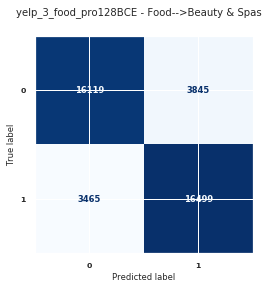

100%|██████████| 1/1 [00:00<00:00, 30.55it/s]

Work on Bicycles ...
#ss (pos) 2
#ss (neg) 2
#nss 4
#~ss 8
review pairs: 8
Start on [prediction] ...
Time for [prediction]: 0:00:00.034123
Confusion Matrix:
[[2 2]
 [2 2]]

CM: [2 2 2 2] 
[tn, fp, fn, tp]
  accuracy: 0.500
 precision: 0.500
    recall: 0.500
  f1-score: 0.500

Accuracy:  0.5 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Bicycles]:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.50      0.50      0.50         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.50         8
weighted avg       0.50      0.50      0.50         8



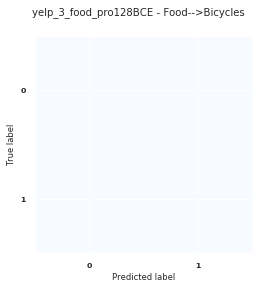

Work on Education ...


 11%|█         | 48/438 [00:00<00:00, 472.66it/s]

#ss (pos) 876
#ss (neg) 876


100%|██████████| 438/438 [00:00<00:00, 482.95it/s]


#nss 1752
#~ss 3504
review pairs: 3504


  1%|          | 1/110 [00:00<00:12,  8.91it/s]

Start on [prediction] ...


100%|██████████| 110/110 [00:11<00:00,  9.95it/s]

Time for [prediction]: 0:00:11.058579
Confusion Matrix:
[[1304  448]
 [ 392 1360]]

CM: [1304  448  392 1360] 
[tn, fp, fn, tp]
  accuracy: 0.760
 precision: 0.761
    recall: 0.760
  f1-score: 0.760

Accuracy:  0.76 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Education]:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1752
           1       0.75      0.78      0.76      1752

    accuracy                           0.76      3504
   macro avg       0.76      0.76      0.76      3504
weighted avg       0.76      0.76      0.76      3504



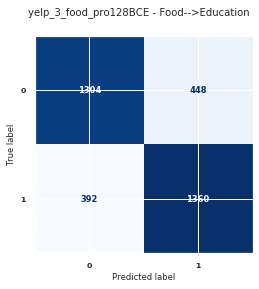

Work on Event Planning & Services ...


  0%|          | 0/3706 [00:00<?, ?it/s]

#ss (pos) 7412
#ss (neg) 7412


100%|██████████| 3706/3706 [00:07<00:00, 486.13it/s]


#nss 14824
#~ss 29648
review pairs: 29648


  0%|          | 1/927 [00:00<01:56,  7.98it/s]

Start on [prediction] ...


100%|██████████| 927/927 [01:30<00:00, 10.27it/s]


Time for [prediction]: 0:01:30.250651
Confusion Matrix:
[[11330  3494]
 [ 3973 10851]]

CM: [11330  3494  3973 10851] 
[tn, fp, fn, tp]
  accuracy: 0.748
 precision: 0.748
    recall: 0.748
  f1-score: 0.748

Accuracy:  0.748 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     14824
           1       0.76      0.73      0.74     14824

    accuracy                           0.75     29648
   macro avg       0.75      0.75      0.75     29648
weighted avg       0.75      0.75      0.75     29648



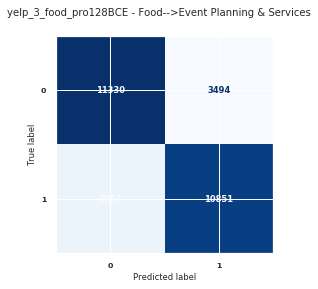

  0%|          | 0/296 [00:00<?, ?it/s]

Work on Financial Services ...


 17%|█▋        | 49/296 [00:00<00:00, 480.92it/s]

#ss (pos) 592
#ss (neg) 592


  0%|          | 0/74 [00:00<?, ?it/s]

#nss 1184
#~ss 2368
review pairs: 2368
Start on [prediction] ...


100%|██████████| 74/74 [00:07<00:00, 10.51it/s]


Time for [prediction]: 0:00:07.041808
Confusion Matrix:
[[943 241]
 [213 971]]

CM: [943 241 213 971] 
[tn, fp, fn, tp]
  accuracy: 0.808
 precision: 0.808
    recall: 0.808
  f1-score: 0.808

Accuracy:  0.808 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Financial Services]:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1184
           1       0.80      0.82      0.81      1184

    accuracy                           0.81      2368
   macro avg       0.81      0.81      0.81      2368
weighted avg       0.81      0.81      0.81      2368



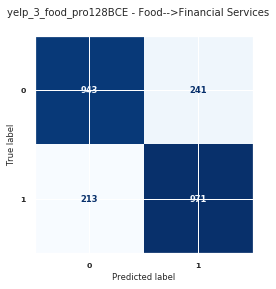

Work on Health & Medical ...


  1%|▏         | 40/3180 [00:00<00:07, 394.09it/s]

#ss (pos) 6360
#ss (neg) 6360


100%|██████████| 3180/3180 [00:06<00:00, 497.65it/s]


#nss 12720
#~ss 25440
review pairs: 25440


  0%|          | 1/795 [00:00<01:30,  8.78it/s]

Start on [prediction] ...


100%|██████████| 795/795 [01:17<00:00, 10.22it/s]


Time for [prediction]: 0:01:17.811201
Confusion Matrix:
[[ 9999  2721]
 [ 2102 10618]]

CM: [ 9999  2721  2102 10618] 
[tn, fp, fn, tp]
  accuracy: 0.810
 precision: 0.811
    recall: 0.810
  f1-score: 0.810

Accuracy:  0.81 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     12720
           1       0.80      0.83      0.81     12720

    accuracy                           0.81     25440
   macro avg       0.81      0.81      0.81     25440
weighted avg       0.81      0.81      0.81     25440



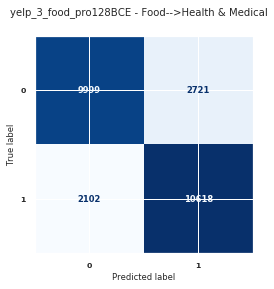

Work on Home Services ...


  1%|          | 38/3093 [00:00<00:08, 375.21it/s]

#ss (pos) 6186
#ss (neg) 6186


100%|██████████| 3093/3093 [00:06<00:00, 493.48it/s]


#nss 12372
#~ss 24744
review pairs: 24744


  0%|          | 1/774 [00:00<01:34,  8.18it/s]

Start on [prediction] ...


100%|██████████| 774/774 [01:16<00:00, 10.09it/s]


Time for [prediction]: 0:01:16.742336
Confusion Matrix:
[[ 9491  2881]
 [ 2220 10152]]

CM: [ 9491  2881  2220 10152] 
[tn, fp, fn, tp]
  accuracy: 0.794
 precision: 0.795
    recall: 0.794
  f1-score: 0.794

Accuracy:  0.794 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Home Services]:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79     12372
           1       0.78      0.82      0.80     12372

    accuracy                           0.79     24744
   macro avg       0.79      0.79      0.79     24744
weighted avg       0.79      0.79      0.79     24744



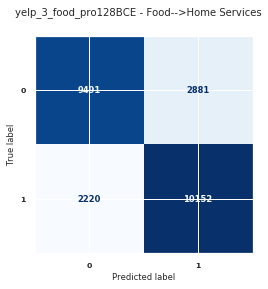

Work on Hotels & Travel ...


  1%|          | 19/2223 [00:00<00:11, 188.56it/s]

#ss (pos) 4446
#ss (neg) 4446


100%|██████████| 2223/2223 [00:04<00:00, 485.45it/s]


#nss 8892
#~ss 17784
review pairs: 17784


  0%|          | 1/556 [00:00<01:01,  9.00it/s]

Start on [prediction] ...


100%|██████████| 556/556 [00:54<00:00, 10.14it/s]


Time for [prediction]: 0:00:54.837513
Confusion Matrix:
[[6575 2317]
 [2277 6615]]

CM: [6575 2317 2277 6615] 
[tn, fp, fn, tp]
  accuracy: 0.742
 precision: 0.742
    recall: 0.742
  f1-score: 0.742

Accuracy:  0.742 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8892
           1       0.74      0.74      0.74      8892

    accuracy                           0.74     17784
   macro avg       0.74      0.74      0.74     17784
weighted avg       0.74      0.74      0.74     17784



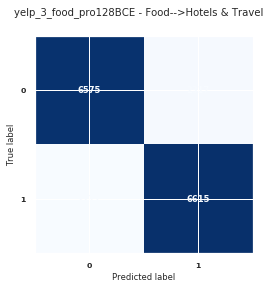

Work on Local Flavor ...


  8%|▊         | 43/508 [00:00<00:01, 427.04it/s]

#ss (pos) 1016
#ss (neg) 1016


100%|██████████| 508/508 [00:01<00:00, 478.46it/s]


#nss 2032
#~ss 4064
review pairs: 4064


  1%|          | 1/127 [00:00<00:13,  9.05it/s]

Start on [prediction] ...


100%|██████████| 127/127 [00:12<00:00, 10.24it/s]


Time for [prediction]: 0:00:12.401679
Confusion Matrix:
[[1461  571]
 [ 560 1472]]

CM: [1461  571  560 1472] 
[tn, fp, fn, tp]
  accuracy: 0.722
 precision: 0.722
    recall: 0.722
  f1-score: 0.722

Accuracy:  0.722 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2032
           1       0.72      0.72      0.72      2032

    accuracy                           0.72      4064
   macro avg       0.72      0.72      0.72      4064
weighted avg       0.72      0.72      0.72      4064



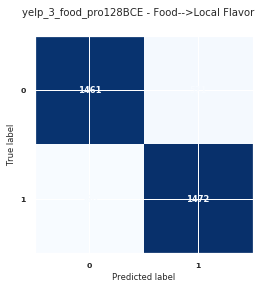

Work on Local Services ...


  2%|▏         | 42/2331 [00:00<00:05, 412.71it/s]

#ss (pos) 4662
#ss (neg) 4662


100%|██████████| 2331/2331 [00:04<00:00, 481.51it/s]


#nss 9324
#~ss 18648
review pairs: 18648


  0%|          | 1/583 [00:00<01:01,  9.42it/s]

Start on [prediction] ...


100%|██████████| 583/583 [00:56<00:00, 10.39it/s]


Time for [prediction]: 0:00:56.091265
Confusion Matrix:
[[7179 2145]
 [1726 7598]]

CM: [7179 2145 1726 7598] 
[tn, fp, fn, tp]
  accuracy: 0.792
 precision: 0.793
    recall: 0.792
  f1-score: 0.792

Accuracy:  0.792 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Local Services]:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9324
           1       0.78      0.81      0.80      9324

    accuracy                           0.79     18648
   macro avg       0.79      0.79      0.79     18648
weighted avg       0.79      0.79      0.79     18648



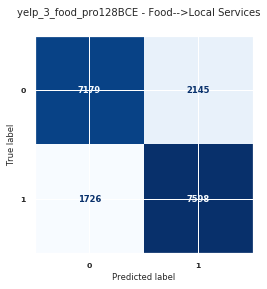

  0%|          | 0/9 [00:00<?, ?it/s]

Work on Mass Media ...
#ss (pos) 70
#ss (neg) 70
#nss 140
#~ss 280
review pairs: 280
Start on [prediction] ...


100%|██████████| 9/9 [00:00<00:00, 10.63it/s]

Time for [prediction]: 0:00:00.847902
Confusion Matrix:
[[100  40]
 [ 32 108]]

CM: [100  40  32 108] 
[tn, fp, fn, tp]
  accuracy: 0.743
 precision: 0.744
    recall: 0.743
  f1-score: 0.743

Accuracy:  0.743 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Mass Media]:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       140
           1       0.73      0.77      0.75       140

    accuracy                           0.74       280
   macro avg       0.74      0.74      0.74       280
weighted avg       0.74      0.74      0.74       280



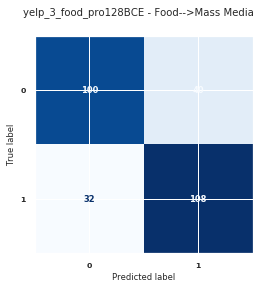

Work on Nightlife ...


100%|██████████| 8157/8157 [00:17<00:00, 475.70it/s]


#ss (pos) 16314
#ss (neg) 16314


100%|██████████| 8157/8157 [00:17<00:00, 473.92it/s]


#nss 32628
#~ss 65256
review pairs: 65256


  0%|          | 1/2040 [00:00<04:21,  7.79it/s]

Start on [prediction] ...


100%|██████████| 2040/2040 [03:15<00:00, 10.45it/s]


Time for [prediction]: 0:03:15.203412
Confusion Matrix:
[[24520  8108]
 [ 9281 23347]]

CM: [24520  8108  9281 23347] 
[tn, fp, fn, tp]
  accuracy: 0.734
 precision: 0.734
    recall: 0.734
  f1-score: 0.733

Accuracy:  0.734 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Nightlife]:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     32628
           1       0.74      0.72      0.73     32628

    accuracy                           0.73     65256
   macro avg       0.73      0.73      0.73     65256
weighted avg       0.73      0.73      0.73     65256



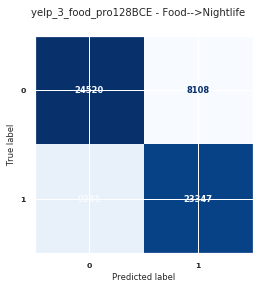

  0%|          | 0/998 [00:00<?, ?it/s]

Work on Pets ...


  5%|▍         | 46/998 [00:00<00:02, 458.80it/s]

#ss (pos) 1996
#ss (neg) 1996


100%|██████████| 998/998 [00:02<00:00, 484.95it/s]


#nss 3992
#~ss 7984
review pairs: 7984


  0%|          | 1/250 [00:00<00:30,  8.05it/s]

Start on [prediction] ...


100%|██████████| 250/250 [00:24<00:00, 10.05it/s]

Time for [prediction]: 0:00:24.887870
Confusion Matrix:
[[3110  882]
 [ 806 3186]]

CM: [3110  882  806 3186] 
[tn, fp, fn, tp]
  accuracy: 0.789
 precision: 0.789
    recall: 0.789
  f1-score: 0.789

Accuracy:  0.789 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Pets]:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      3992
           1       0.78      0.80      0.79      3992

    accuracy                           0.79      7984
   macro avg       0.79      0.79      0.79      7984
weighted avg       0.79      0.79      0.79      7984



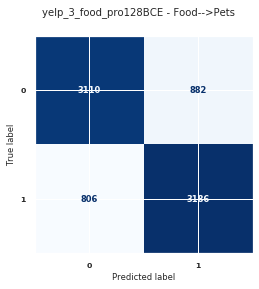

Work on Professional Services ...


  7%|▋         | 47/705 [00:00<00:01, 465.74it/s]

#ss (pos) 1410
#ss (neg) 1410


100%|██████████| 705/705 [00:01<00:00, 493.56it/s]


#nss 2820
#~ss 5640
review pairs: 5640


  1%|          | 1/177 [00:00<00:19,  9.13it/s]

Start on [prediction] ...


100%|██████████| 177/177 [00:17<00:00, 10.40it/s]

Time for [prediction]: 0:00:17.014815
Confusion Matrix:
[[2191  629]
 [ 484 2336]]

CM: [2191  629  484 2336] 
[tn, fp, fn, tp]
  accuracy: 0.803
 precision: 0.803
    recall: 0.803
  f1-score: 0.803

Accuracy:  0.803 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Professional Services]:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2820
           1       0.79      0.83      0.81      2820

    accuracy                           0.80      5640
   macro avg       0.80      0.80      0.80      5640
weighted avg       0.80      0.80      0.80      5640



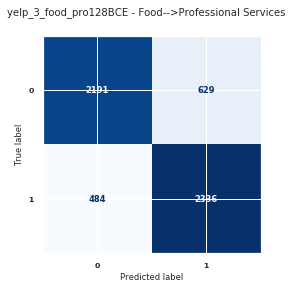

  0%|          | 0/290 [00:00<?, ?it/s]

Work on Public Services & Government ...


 17%|█▋        | 49/290 [00:00<00:00, 481.13it/s]

#ss (pos) 580
#ss (neg) 580


  0%|          | 0/73 [00:00<?, ?it/s]

#nss 1160
#~ss 2320
review pairs: 2320
Start on [prediction] ...


100%|██████████| 73/73 [00:06<00:00, 10.44it/s]

Time for [prediction]: 0:00:06.991740
Confusion Matrix:
[[787 373]
 [306 854]]

CM: [787 373 306 854] 
[tn, fp, fn, tp]
  accuracy: 0.707
 precision: 0.708
    recall: 0.707
  f1-score: 0.707

Accuracy:  0.707 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Public Services & Government]:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1160
           1       0.70      0.74      0.72      1160

    accuracy                           0.71      2320
   macro avg       0.71      0.71      0.71      2320
weighted avg       0.71      0.71      0.71      2320



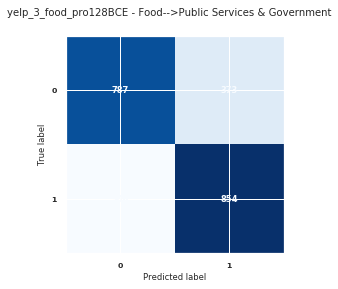

100%|██████████| 43/43 [00:00<00:00, 483.49it/s]


Work on Religious Organizations ...
#ss (pos) 86
#ss (neg) 86


100%|██████████| 43/43 [00:00<00:00, 496.50it/s]

#nss 172
#~ss 344
review pairs: 344



  0%|          | 0/11 [00:00<?, ?it/s]

Start on [prediction] ...


100%|██████████| 11/11 [00:01<00:00, 10.44it/s]

Time for [prediction]: 0:00:01.054416
Confusion Matrix:
[[117  55]
 [ 45 127]]

CM: [117  55  45 127] 
[tn, fp, fn, tp]
  accuracy: 0.709
 precision: 0.710
    recall: 0.709
  f1-score: 0.709

Accuracy:  0.709 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Religious Organizations]:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       172
           1       0.70      0.74      0.72       172

    accuracy                           0.71       344
   macro avg       0.71      0.71      0.71       344
weighted avg       0.71      0.71      0.71       344



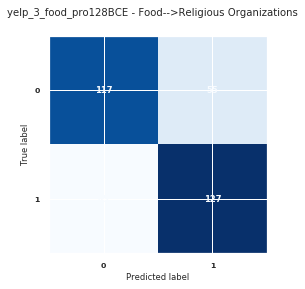

Work on Restaurants ...


100%|██████████| 33354/33354 [01:13<00:00, 455.21it/s]


#ss (pos) 66708
#ss (neg) 66708


100%|██████████| 33354/33354 [01:11<00:00, 466.89it/s]


#nss 133416
#~ss 266832
review pairs: 266832


  0%|          | 1/8339 [00:00<17:01,  8.16it/s]

Start on [prediction] ...


100%|██████████| 8339/8339 [13:10<00:00, 10.55it/s]


Time for [prediction]: 0:13:10.128088
Confusion Matrix:
[[102966  30450]
 [ 37017  96399]]

CM: [102966  30450  37017  96399] 
[tn, fp, fn, tp]
  accuracy: 0.747
 precision: 0.748
    recall: 0.747
  f1-score: 0.747

Accuracy:  0.747 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Restaurants]:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75    133416
           1       0.76      0.72      0.74    133416

    accuracy                           0.75    266832
   macro avg       0.75      0.75      0.75    266832
weighted avg       0.75      0.75      0.75    266832



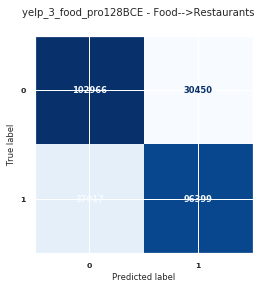

Work on Shopping ...


  0%|          | 0/6597 [00:00<?, ?it/s]

#ss (pos) 13194
#ss (neg) 13194


100%|██████████| 6597/6597 [00:13<00:00, 482.85it/s]


#nss 26388
#~ss 52776
review pairs: 52776


  0%|          | 1/1650 [00:00<04:44,  5.80it/s]

Start on [prediction] ...


100%|██████████| 1650/1650 [02:38<00:00, 10.38it/s]


Time for [prediction]: 0:02:38.910807
Confusion Matrix:
[[19935  6453]
 [ 6217 20171]]

CM: [19935  6453  6217 20171] 
[tn, fp, fn, tp]
  accuracy: 0.760
 precision: 0.760
    recall: 0.760
  f1-score: 0.760

Accuracy:  0.76 

Report for [BERTClassifier - yelp_3_food_pro128BCE - Food-->Shopping]:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     26388
           1       0.76      0.76      0.76     26388

    accuracy                           0.76     52776
   macro avg       0.76      0.76      0.76     52776
weighted avg       0.76      0.76      0.76     52776



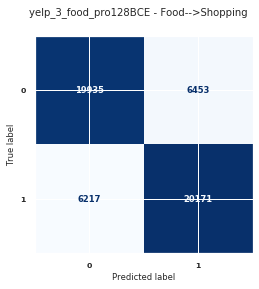

In [77]:
results_cross_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # with overlap
    df_other = load_cached_root_category_businesses_df(root_category_label, map_categories)
    
    df_other = filter_min_review_freq(df_other, min_ratings=5)
    df_other = filter_both_good_bad(df_other)
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=2)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    results_cross_overlap[root_category_label] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [85]:
results_cross_no_overlap

{'Active Life': (0.7510721014465412,
  0.7510157440325038,
  0.7510017710580055,
  0.7510157440325038,
  array([[5974, 1902],
         [2020, 5856]])),
 'Arts & Entertainment': (0.7099114015997936,
  0.7099068479355488,
  0.7099052746599093,
  0.7099068479355488,
  array([[5621, 2323],
         [2286, 5658]])),
 'Automotive': (0.7946663327730041,
  0.7941694475342973,
  0.794082639774715,
  0.7941694475342974,
  array([[8346, 2442],
         [1999, 8789]])),
 'Beauty & Spas': (0.8177700246749287,
  0.8177051202961135,
  0.8176958114098145,
  0.8177051202961135,
  array([[15767,  3685],
         [ 3407, 16045]])),
 'Bicycles': (0.8333333333333333,
  0.75,
  0.7333333333333334,
  0.75,
  array([[2, 2],
         [0, 4]])),
 'Education': (0.7564554883056054,
  0.7564338235294117,
  0.7564286794416579,
  0.7564338235294118,
  array([[1227,  405],
         [ 390, 1242]])),
 'Event Planning & Services': (0.7431693683752096,
  0.7431233723958333,
  0.7431112246375727,
  0.7431233723958334,
  a

In [86]:
results_cross_overlap

{'Active Life': (0.7422758584029843,
  0.7422756253065228,
  0.7422755633165925,
  0.7422756253065228,
  array([[6058, 2098],
         [2106, 6050]])),
 'Arts & Entertainment': (0.7099619643017017,
  0.7099605089951733,
  0.7099600064076004,
  0.7099605089951733,
  array([[6484, 2632],
         [2656, 6460]])),
 'Automotive': (0.7901753241619228,
  0.7895891853932584,
  0.7894828770367563,
  0.7895891853932584,
  array([[8739, 2653],
         [2141, 9251]])),
 'Beauty & Spas': (0.8170353197069233,
  0.8169204568222801,
  0.81690387274786,
  0.8169204568222801,
  array([[16119,  3845],
         [ 3465, 16499]])),
 'Bicycles': (0.5,
  0.5,
  0.5,
  0.5,
  array([[2, 2],
         [2, 2]])),
 'Education': (0.7605401569544163,
  0.7602739726027397,
  0.7602127271305299,
  0.7602739726027398,
  array([[1304,  448],
         [ 392, 1360]])),
 'Event Planning & Services': (0.7484042579239436,
  0.7481449001618996,
  0.7480791428050407,
  0.7481449001618996,
  array([[11330,  3494],
         [ 

In [88]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (prec, rec, f1, acc, cm) in results_cross_no_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 75.11%  75.10%  75.10%  75.10%  -- [5974, 1902, 2020, 5856]
Arts & Entertainment          : 70.99%  70.99%  70.99%  70.99%  -- [5621, 2323, 2286, 5658]
Automotive                    : 79.47%  79.42%  79.41%  79.42%  -- [8346, 2442, 1999, 8789]
Beauty & Spas                 : 81.78%  81.77%  81.77%  81.77%  -- [15767, 3685, 3407, 16045]
Bicycles                      : 83.33%  75.00%  73.33%  75.00%  -- [2, 2, 0, 4]
Education                     : 75.65%  75.64%  75.64%  75.64%  -- [1227, 405, 390, 1242]
Event Planning & Services     : 74.32%  74.31%  74.31%  74.31%  -- [9216, 3072, 3241, 9047]
Financial Services            : 80.56%  80.53%  80.52%  80.53%  -- [928, 248, 210, 966]
Health & Medical              : 81.62%  81.56%  81.55%  81.56%  -- [9825, 2547, 2016, 10356]
Home Services                 : 79.71%  79.61%  79.59%  79.61%  -- [9418, 2858, 2149, 10127]


In [87]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (prec, rec, f1, acc, cm) in results_cross_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 74.23%  74.23%  74.23%  74.23%  -- [6058, 2098, 2106, 6050]
Arts & Entertainment          : 71.00%  71.00%  71.00%  71.00%  -- [6484, 2632, 2656, 6460]
Automotive                    : 79.02%  78.96%  78.95%  78.96%  -- [8739, 2653, 2141, 9251]
Beauty & Spas                 : 81.70%  81.69%  81.69%  81.69%  -- [16119, 3845, 3465, 16499]
Bicycles                      : 50.00%  50.00%  50.00%  50.00%  -- [2, 2, 2, 2]
Education                     : 76.05%  76.03%  76.02%  76.03%  -- [1304, 448, 392, 1360]
Event Planning & Services     : 74.84%  74.81%  74.81%  74.81%  -- [11330, 3494, 3973, 10851]
Financial Services            : 80.84%  80.83%  80.83%  80.83%  -- [943, 241, 213, 971]
Health & Medical              : 81.12%  81.04%  81.03%  81.04%  -- [9999, 2721, 2102, 10618]
Home Services                 : 79.47%  79.38%  79.37%  79.38%  -- [9491, 2881, 2220, 10152

In [90]:
fn_results = fn_run_path / "results_cross_dicts.p"

with open(fn_results, "wb") as fp:
    pickle.dump(("Food", "overlap", results_cross_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(("Food", "no overlap", results_cross_no_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)